In [1]:
# Full upgraded SenTAT model with all suggested improvements

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, utils

# Load dataset
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

# Normalize sensor data
sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Encode labels
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# Sliding window
window_size = 128
stride = window_size // 2

X, y = [], []
for class_label in df['Class'].unique():
    data_class = df[df['Class'] == class_label]
    values = data_class[sensor_cols].values
    for start in range(0, len(values) - window_size + 1, stride):
        X.append(values[start:start+window_size])
        y.append(class_label)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Positional Encoding Layer
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, length, dim):
        super().__init__()
        pos = np.arange(length)[:, np.newaxis]
        i = np.arange(dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# Build upgraded SenTAT model
inputs = layers.Input(shape=(window_size, 6))
acc = layers.Lambda(lambda x: x[:, :, :3])(inputs)
gyro = layers.Lambda(lambda x: x[:, :, 3:])(inputs)

# Embeddings
acc_emb = layers.Dense(32)(acc)
gyro_emb = layers.Dense(32)(gyro)

# Positional Encoding
acc_emb = PositionalEncoding(window_size, 32)(acc_emb)
gyro_emb = PositionalEncoding(window_size, 32)(gyro_emb)

# Multi-head attention with residual and LayerNorm
def sensor_attention_block(x, num_heads=2, key_dim=32):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn = layers.Add()([x, attn])  # Residual connection
    attn = layers.LayerNormalization()(attn)
    ffn = layers.Dense(64, activation='relu')(attn)
    ffn = layers.Dense(32)(ffn)
    ffn = layers.Add()([attn, ffn])  # Second residual
    return layers.LayerNormalization()(ffn)

attn_acc = sensor_attention_block(acc_emb)
attn_gyro = sensor_attention_block(gyro_emb)

# Fusion
concat = layers.Concatenate()([attn_acc, attn_gyro])
gap = layers.GlobalAveragePooling1D()(concat)
dense = layers.Dense(64, activation='relu')(gap)
drop = layers.Dropout(0.5)(dense)
output = layers.Dense(num_classes, activation='softmax')(drop)

model = models.Model(inputs, output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

 # Train
model.fit(X_train, y_train_cat, epochs=200, batch_size=64, validation_split=0.1)

# Evaluate
y_pred_dl_probs = model.predict(X_test)
y_pred_dl = np.argmax(y_pred_dl_probs, axis=1)

print("=== Deep Learning Model Evaluation ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dl))
print("Classification Report:\n", classification_report(y_test, y_pred_dl))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dl))
print("ROC AUC (macro):", roc_auc_score(y_test_cat, y_pred_dl_probs, multi_class='ovr'))

Epoch 1/200
13/13 [==============================] - 44s 63ms/step - loss: 1.6684 - accuracy: 0.2320 - val_loss: 1.4403 - val_accuracy: 0.4556
Epoch 2/200
13/13 [==============================] - 0s 12ms/step - loss: 1.4602 - accuracy: 0.3635 - val_loss: 1.3301 - val_accuracy: 0.4889
Epoch 3/200
13/13 [==============================] - 0s 13ms/step - loss: 1.3760 - accuracy: 0.3846 - val_loss: 1.2199 - val_accuracy: 0.5778
Epoch 4/200
13/13 [==============================] - 0s 11ms/step - loss: 1.2773 - accuracy: 0.4615 - val_loss: 1.0676 - val_accuracy: 0.5889
Epoch 5/200
13/13 [==============================] - 0s 13ms/step - loss: 1.1923 - accuracy: 0.4901 - val_loss: 0.9605 - val_accuracy: 0.6556
Epoch 6/200
13/13 [==============================] - 0s 12ms/step - loss: 1.0794 - accuracy: 0.5819 - val_loss: 0.8410 - val_accuracy: 0.7000
Epoch 7/200
13/13 [==============================] - 0s 12ms/step - loss: 0.9982 - accuracy: 0.6104 - val_loss: 0.7633 - val_accuracy: 0.7222
Epoch

DeepConvLSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 124, 64)           1984      
                                                                 
 conv1d_1 (Conv1D)           (None, 120, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 58, 128)           24704     
                                                                 
 conv1d_3 (Conv1D)           (None, 56, 128)           49280     
                                                        

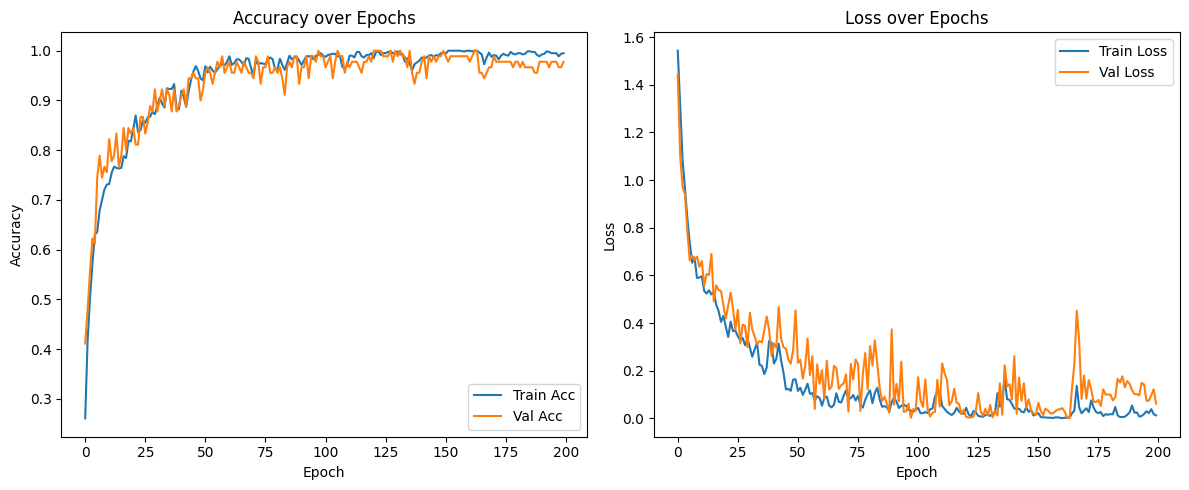

=== DeepConvLSTM Model Evaluation ===
7/7 [==============================] - 1s 4ms/step
Test Inference Time Total: 0.6181s; Per Sample: 0.002759s
Test Accuracy: 0.9866
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       0.98      0.98      0.98        58
           2       0.97      0.95      0.96        40
           3       1.00      1.00      1.00        51
           4       1.00      1.00      1.00        45

    accuracy                           0.99       224
   macro avg       0.98      0.99      0.99       224
weighted avg       0.99      0.99      0.99       224

Confusion Matrix:
 [[30  0  0  0  0]
 [ 0 57  1  0  0]
 [ 1  1 38  0  0]
 [ 0  0  0 51  0]
 [ 0  0  0  0 45]]
ROC AUC (macro): 0.9993047022321655


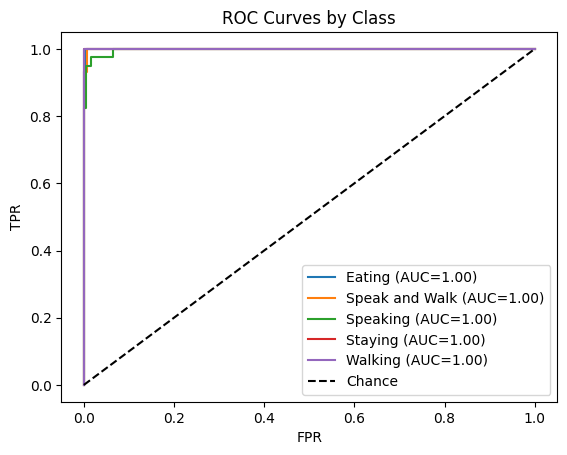

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)
import tensorflow as tf
from tensorflow.keras import layers, models, utils

# 1. Load and preprocess the data
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

# Normalize sensor data
sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Encode labels
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# Sliding window
window_size = 128
stride = window_size // 2
X, y = [], []
for class_label in df['Class'].unique():
    data_class = df[df['Class'] == class_label]
    values = data_class[sensor_cols].values
    for start in range(0, len(values) - window_size + 1, stride):
        X.append(values[start:start+window_size])
        y.append(class_label)
X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# 2. Define DeepConvLSTM model
def build_deepconvlstm(input_shape, num_classes):
    model = models.Sequential()
    # Convolutional blocks
    model.add(layers.Conv1D(64, 5, activation='relu', input_shape=input_shape))
    model.add(layers.Conv1D(64, 5, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Dropout(0.5))

    # LSTM block
    model.add(layers.LSTM(128, return_sequences=False))
    model.add(layers.Dropout(0.5))

    # Output
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

input_shape = (window_size, len(sensor_cols))
model = build_deepconvlstm(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary and size
model.summary()
param_count = model.count_params()
print("Model parameter count:", param_count)

# Save model temporarily and report file size
model_path = 'deepconvlstm_model.h5'
model.save(model_path)
model_file_size = os.path.getsize(model_path) / (1024 * 1024)  # in MB
print(f"Saved model file size: {model_file_size:.2f} MB")

# 3. Train the model with validation split
history = model.fit(
    X_train, y_train_cat,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 4. Plot training vs validation accuracy & loss
plt.figure(figsize=(12,5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout()
plt.show()

# 5. Evaluate on test set with timing
print("=== DeepConvLSTM Model Evaluation ===")
start_time = time.time()
y_pred_probs = model.predict(X_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
print(f"Test Inference Time Total: {inference_time:.4f}s; Per Sample: {inference_time/len(X_test):.6f}s")
print(f"Test Accuracy: {np.mean(y_pred == y_test):.4f}")

# Detailed metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC AUC scores
macro_auc = roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr')
print("ROC AUC (macro):", macro_auc)

# 6. ROC Curve plot per class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{le.inverse_transform([i])[0]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.title('ROC Curves by Class')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(loc='lower right')
plt.show()


LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          69120     
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 3

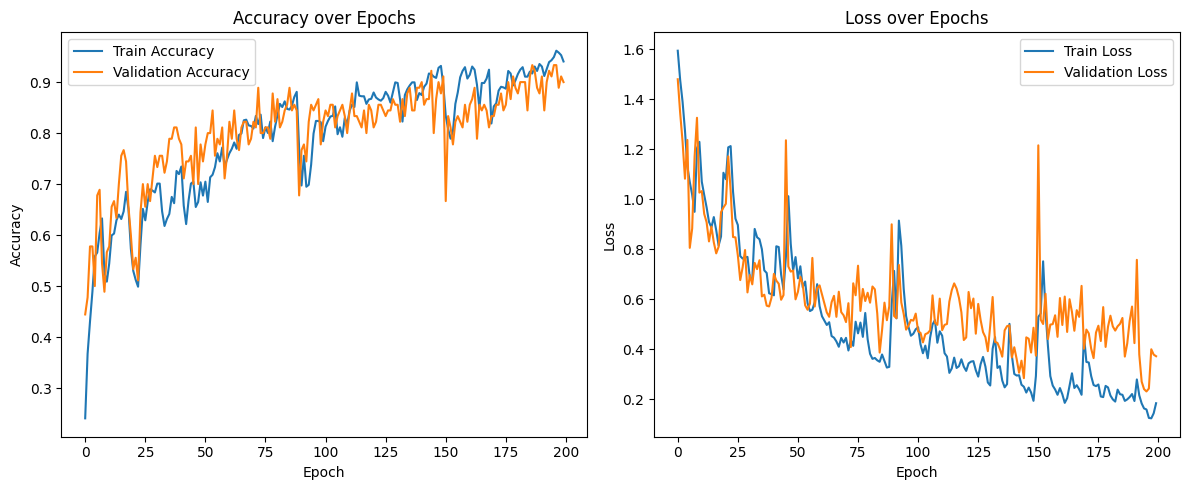

=== DeepConvLSTM Model Evaluation ===
7/7 [==============================] - 0s 6ms/step
Test Inference Time Total: 0.4493s, Per Sample: 0.002006s
Test Accuracy: 0.8839
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        30
           1       0.95      0.90      0.92        58
           2       0.74      0.85      0.79        40
           3       1.00      0.88      0.94        51
           4       0.90      0.96      0.92        45

    accuracy                           0.88       224
   macro avg       0.88      0.88      0.87       224
weighted avg       0.89      0.88      0.89       224

Confusion Matrix:
 [[24  0  6  0  0]
 [ 0 52  1  0  5]
 [ 5  1 34  0  0]
 [ 1  0  5 45  0]
 [ 0  2  0  0 43]]
ROC AUC (macro): 0.9898854223596079


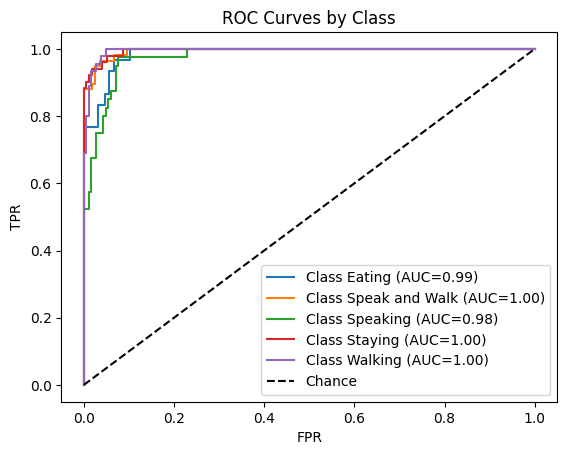

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, utils

# 1. Load and preprocess the data
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

# Normalize sensor data
sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Encode labels
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# Sliding window
window_size = 128
stride = window_size // 2
X, y = [], []
for class_label in df['Class'].unique():
    data_class = df[df['Class'] == class_label]
    values = data_class[sensor_cols].values
    for start in range(0, len(values) - window_size + 1, stride):
        X.append(values[start:start+window_size])
        y.append(class_label)
X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# 2. Define pure LSTM model
def build_lstm(input_shape, num_classes):
    model = models.Sequential()
    # First LSTM layer with return_sequences=True for stacking
    model.add(layers.LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(layers.Dropout(0.5))
    # Second LSTM layer
    model.add(layers.LSTM(units=64, return_sequences=False))
    model.add(layers.Dropout(0.5))

    # Fully connected layers
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(units=num_classes, activation='softmax'))
    return model

# Build and compile pure LSTM model
input_shape = (window_size, len(sensor_cols))
model = build_lstm(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary and compute size
def report_model_size(m):
    m.summary()
    params = m.count_params()
    print("Model parameter count:", params)
    # Save to temp file to get disk size
    import os
    temp_path = 'lstm_model.h5'
    m.save(temp_path)
    size_mb = os.path.getsize(temp_path) / (1024 * 1024)
    print(f"Saved model file size: {size_mb:.2f} MB")

report_model_size(model)

# Print header for evaluation
print("=== Pure LSTM Model Ready for Training ===")

# 3. Train the model with validation split
model.summary()
param_count = model.count_params()
print("Model parameter count:", param_count)

# Save model temporarily and report file size
import os
model_path = 'deepconvlstm_model.h5'
model.save(model_path)
model_file_size = os.path.getsize(model_path) / (1024 * 1024)  # in MB
print(f"Saved model file size: {model_file_size:.2f} MB")

# 3. Train the model with validation split
history = model.fit(
    X_train, y_train_cat,
    epochs=200,  # changed to 200 epochs
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 4. Plot training vs validation accuracy & loss
plt.figure(figsize=(12,5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 5. Evaluate on test set with timing
print("=== DeepConvLSTM Model Evaluation ===")
start_time = time.time()
y_pred_probs = model.predict(X_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
print(f"Test Inference Time Total: {inference_time:.4f}s, Per Sample: {inference_time/len(X_test):.6f}s")
print(f"Test Accuracy: {np.mean(y_pred == y_test):.4f}")

# Detailed metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC AUC scores
macro_auc = roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr')
print("ROC AUC (macro):", macro_auc)

# 6. ROC Curve plot per class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {le.inverse_transform([i])[0]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.title('ROC Curves by Class')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()


Bi‑LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128, 256)         138240    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

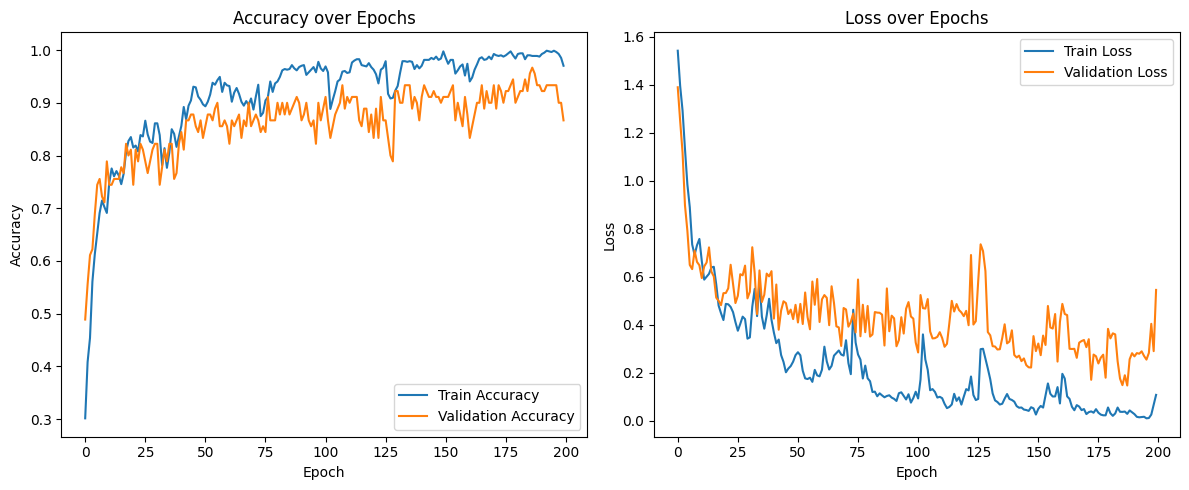

=== DeepConvLSTM Model Evaluation ===
7/7 [==============================] - 1s 17ms/step
Test Inference Time Total: 0.8117s, Per Sample: 0.003624s
Test Accuracy: 0.9018
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.82      0.95      0.88        58
           2       0.85      0.88      0.86        40
           3       1.00      0.94      0.97        51
           4       0.95      0.82      0.88        45

    accuracy                           0.90       224
   macro avg       0.91      0.90      0.90       224
weighted avg       0.91      0.90      0.90       224

Confusion Matrix:
 [[27  0  3  0  0]
 [ 0 55  1  0  2]
 [ 0  5 35  0  0]
 [ 2  0  1 48  0]
 [ 0  7  1  0 37]]
ROC AUC (macro): 0.9862500404961079


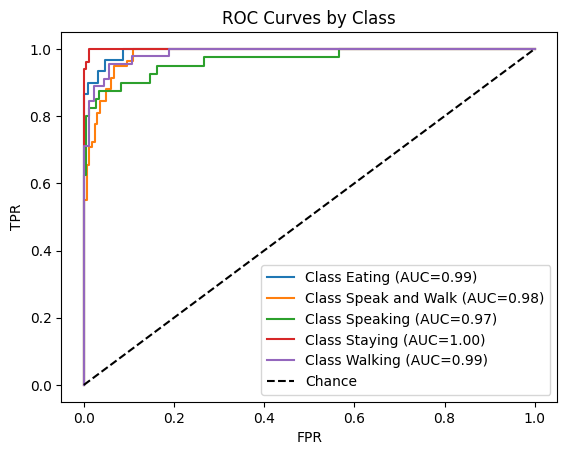

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, utils

# 1. Load and preprocess the data
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

# Normalize sensor data
sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Encode labels
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# Sliding window
window_size = 128
stride = window_size // 2
X, y = [], []
for class_label in df['Class'].unique():
    data_class = df[df['Class'] == class_label]
    values = data_class[sensor_cols].values
    for start in range(0, len(values) - window_size + 1, stride):
        X.append(values[start:start+window_size])
        y.append(class_label)
X = np.array(X)
y = np.array(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# 2. Define Bi‑LSTM model
def build_bilstm(input_shape, num_classes):
    model = models.Sequential()
    # First Bidirectional LSTM layer
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(layers.Dropout(0.5))
    # Second Bidirectional LSTM layer
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=False)))
    model.add(layers.Dropout(0.5))

    # Fully connected layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Build and compile Bi‑LSTM model
input_shape = (window_size, len(sensor_cols))
model = build_bilstm(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary and compute size
def report_model_size(m, filename='bilstm_model.h5'):
    m.summary()
    params = m.count_params()
    print("Model parameter count:", params)
    # Save to temp file to get disk size
    import os
    m.save(filename)
    size_mb = os.path.getsize(filename) / (1024 * 1024)
    print(f"Saved model file size: {size_mb:.2f} MB")

report_model_size(model, 'bilstm_model.h5')

# Print header for evaluation
print("=== Pure LSTM Model Ready for Training ===")

# 3. Train the model with validation split
model.summary()
param_count = model.count_params()
print("Model parameter count:", param_count)

# Save model temporarily and report file size
import os
model_path = 'deepconvlstm_model.h5'
model.save(model_path)
model_file_size = os.path.getsize(model_path) / (1024 * 1024)  # in MB
print(f"Saved model file size: {model_file_size:.2f} MB")

# 3. Train the model with validation split
history = model.fit(
    X_train, y_train_cat,
    epochs=200,  # changed to 200 epochs
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 4. Plot training vs validation accuracy & loss
plt.figure(figsize=(12,5))
# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 5. Evaluate on test set with timing
print("=== DeepConvLSTM Model Evaluation ===")
start_time = time.time()
y_pred_probs = model.predict(X_test)
inference_time = time.time() - start_time

y_pred = np.argmax(y_pred_probs, axis=1)
print(f"Test Inference Time Total: {inference_time:.4f}s, Per Sample: {inference_time/len(X_test):.6f}s")
print(f"Test Accuracy: {np.mean(y_pred == y_test):.4f}")

# Detailed metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC AUC scores
macro_auc = roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr')
print("ROC AUC (macro):", macro_auc)

# 6. ROC Curve plot per class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {le.inverse_transform([i])[0]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], 'k--', label='Chance')
plt.title('ROC Curves by Class')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()


DanHAR: Dual Attention Network

Model: "DanHAR_full"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 acc_input (InputLayer)         [(None, 128, 3)]     0           []                               
                                                                                                  
 gyro_input (InputLayer)        [(None, 128, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 128, 64)      640         ['acc_input[0][0]']              
                                                                                                  
 conv1d_9 (Conv1D)              (None, 128, 64)      640         ['gyro_input[0][0]']             
                                                                                        

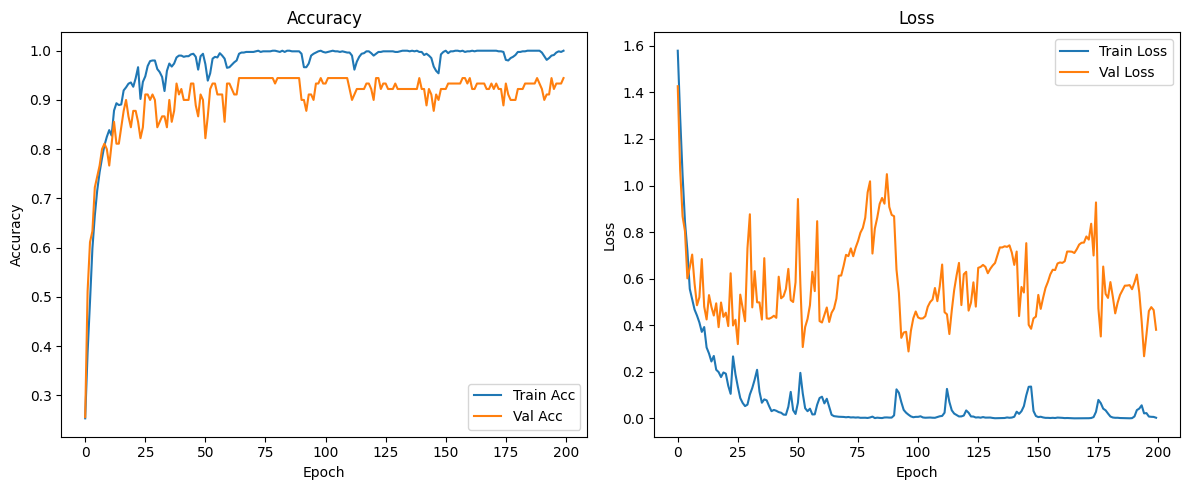

=== DanHAR Full Model Evaluation ===
7/7 [==============================] - 0s 4ms/step
Inference time: 0.5129s (0.002290s/sample)
Test Accuracy: 0.9464
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.95      0.91      0.93        58
           2       0.97      0.88      0.92        40
           3       0.98      1.00      0.99        51
           4       0.90      0.98      0.94        45

    accuracy                           0.95       224
   macro avg       0.95      0.95      0.95       224
weighted avg       0.95      0.95      0.95       224

Confusion Matrix:
 [[29  0  1  0  0]
 [ 0 53  0  0  5]
 [ 2  2 35  1  0]
 [ 0  0  0 51  0]
 [ 0  1  0  0 44]]
ROC AUC (macro): 0.996066780387804


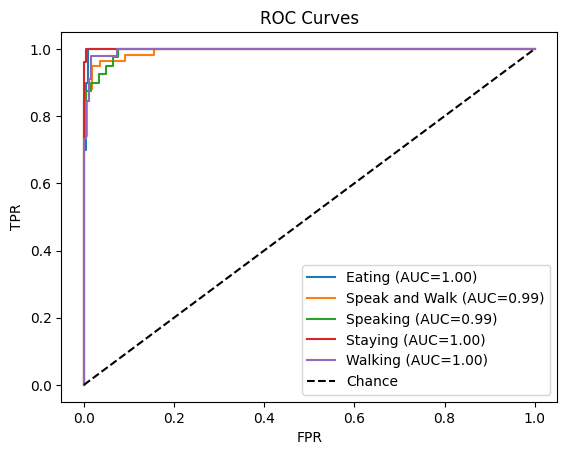

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import layers, models, utils, Input

# 1. Load and preprocess the data
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

# Normalize sensor data
sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

# Encode labels
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# Sliding window
window_size = 128
stride = window_size // 2
X, y = [], []
for class_label in df['Class'].unique():
    data_class = df[df['Class'] == class_label]
    values = data_class[sensor_cols].values
    for start in range(0, len(values) - window_size + 1, stride):
        X.append(values[start:start+window_size])
        y.append(class_label)
X = np.array(X)
y = np.array(y)

# Prepare multimodal inputs
X_acc = X[:, :, :3]
X_gyro = X[:, :, 3:]

# Train/test split
X_acc_train, X_acc_test, X_gyro_train, X_gyro_test, y_train, y_test = train_test_split(
    X_acc, X_gyro, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# Dual Attention Modules (CBAM style)
def channel_attention(inputs, reduction=16):
    channel = inputs.shape[-1]
    shared_one = layers.Dense(channel // reduction, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_two = layers.Dense(channel, kernel_initializer='he_normal', use_bias=True)
    avg_pool = layers.GlobalAveragePooling1D()(inputs)
    avg_pool = layers.Reshape((1, channel))(avg_pool)
    avg_out = shared_two(shared_one(avg_pool))
    max_pool = layers.GlobalMaxPooling1D()(inputs)
    max_pool = layers.Reshape((1, channel))(max_pool)
    max_out = shared_two(shared_one(max_pool))
    cbam = layers.Add()([avg_out, max_out])
    cbam = layers.Activation('sigmoid')(cbam)
    return layers.Multiply()([inputs, cbam])

def spatial_attention(inputs):
    avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    cbam = layers.Conv1D(1, kernel_size=7, padding='same', activation='sigmoid', use_bias=False)(concat)
    return layers.Multiply()([inputs, cbam])

# Build DanHAR branch

def danhar_branch(x):
    for filters in [64, 128, 256]:
        x = layers.Conv1D(filters, 3, padding='same', activation='relu')(x)
        x = layers.Conv1D(filters, 3, padding='same', activation='relu')(x)
        x = channel_attention(x)
        x = spatial_attention(x)
        x = layers.MaxPooling1D(2)(x)
    return x

# 2. Define full multimodal DanHAR model
acc_input = Input(shape=(window_size, 3), name='acc_input')
gyro_input = Input(shape=(window_size, 3), name='gyro_input')
acc_feat = danhar_branch(acc_input)
gyro_feat = danhar_branch(gyro_input)

# Fusion and attention
x = layers.Concatenate(axis=-1)([acc_feat, gyro_feat])
x = channel_attention(x)
x = spatial_attention(x)

# Classification head
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

danhar_model = models.Model([acc_input, gyro_input], outputs, name='DanHAR_full')
danhar_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Report model size and parameters
def report_model_size(m, filename='danhar_full_model.h5'):
    m.summary()
    print("Model parameter count:", m.count_params())
    m.save(filename)
    print(f"Saved model file size: {os.path.getsize(filename)/(1024*1024):.2f} MB")

report_model_size(danhar_model)

# 3. Train DanHAR_full
history = danhar_model.fit(
    [X_acc_train, X_gyro_train], y_train_cat,
    epochs=200,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 4. Plot metrics
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout(); plt.show()

# 5. Evaluate DanHAR_full
print("=== DanHAR Full Model Evaluation ===")
start = time.time()
y_pred_probs = danhar_model.predict([X_acc_test, X_gyro_test])
inf_time = time.time() - start

y_pred = np.argmax(y_pred_probs, axis=1)
print(f"Inference time: {inf_time:.4f}s ({inf_time/len(X_acc_test):.6f}s/sample)")
print(f"Test Accuracy: {np.mean(y_pred==y_test):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
macro_auc = roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr')
print("ROC AUC (macro):", macro_auc)

# 6. ROC Curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{le.inverse_transform([i])[0]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--',label='Chance')
plt.title('ROC Curves')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(loc='lower right')
plt.show()


HART / MobileHART (2023)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 6)]     0           []                               
                                                                                                  
 lambda_2 (Lambda)              (None, 128, 3)       0           ['input_2[0][0]']                
                                                                                                  
 lambda_3 (Lambda)              (None, 128, 3)       0           ['input_2[0][0]']                
                                                                                                  
 separable_conv1d_4 (SeparableC  (None, 128, 64)     265         ['lambda_2[0][0]']               
 onv1D)                                                                                     

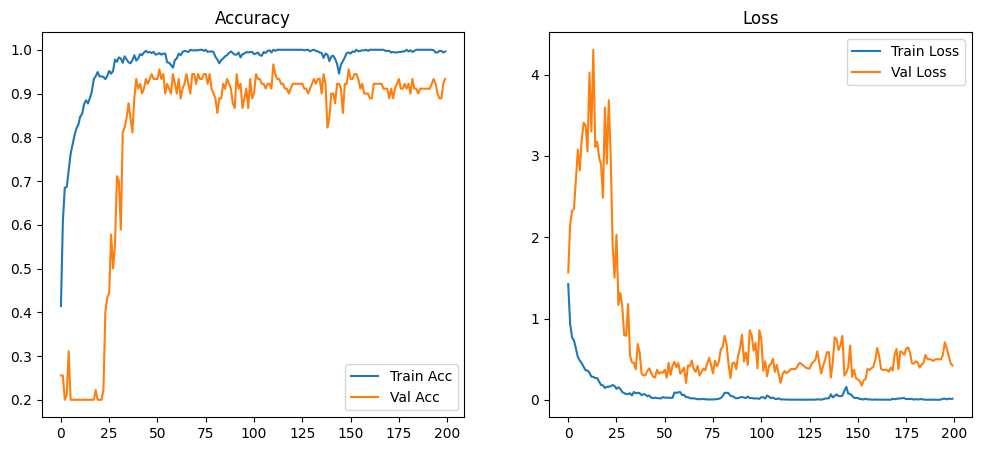

=== Full HART Evaluation ===
7/7 [==============================] - 0s 4ms/step
Test accuracy: 0.9330357142857143
ROC AUC: 0.9952443221126839
Inference time: 0.382s (0.00171s/sample)
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       0.96      0.86      0.91        58
           2       0.95      0.90      0.92        40
           3       1.00      1.00      1.00        51
           4       0.85      0.98      0.91        45

    accuracy                           0.93       224
   macro avg       0.93      0.93      0.93       224
weighted avg       0.94      0.93      0.93       224

Confusion Matrix:
 [[28  0  2  0  0]
 [ 0 50  0  0  8]
 [ 3  1 36  0  0]
 [ 0  0  0 51  0]
 [ 0  1  0  0 44]]


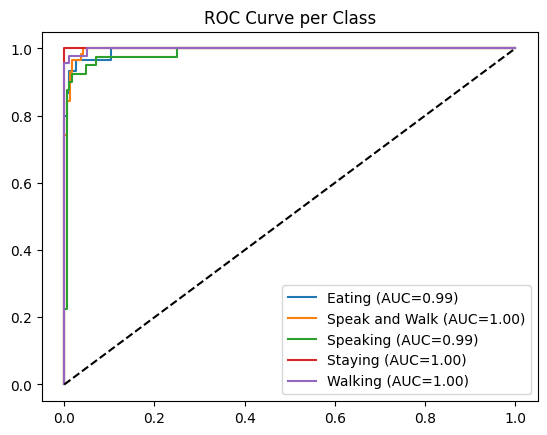

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score,
    roc_curve, auc
)
import tensorflow as tf
from tensorflow.keras import layers, models, utils

# Load and preprocess
df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time','Person'], axis=1)

sensor_cols = ['Acc_x','Acc_y','Acc_z','Gry_x','Gry_y','Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

window_size = 128
stride = window_size // 2
X, y = [], []
for label in df['Class'].unique():
    vals = df[df['Class']==label][sensor_cols].values
    for start in range(0, len(vals)-window_size+1, stride):
        X.append(vals[start:start+window_size])
        y.append(label)
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

class PositionalEncoding(layers.Layer):
    def __init__(self, length, dim):
        super().__init__()
        self.length = length
        self.dim = dim
        pos = np.arange(length)[:, np.newaxis]
        i = np.arange(dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(dim))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

    def get_config(self):
        config = super().get_config()
        config.update({
            "length": self.length,
            "dim": self.dim,
        })
        return config


# Sensor-specific transformer block
def transformer_block(x, num_heads=2, key_dim=32, ffn_dim=64):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn = layers.Add()([x, attn])
    attn = layers.LayerNormalization()(attn)

    ffn = layers.Dense(ffn_dim, activation='relu')(attn)
    ffn = layers.Dense(key_dim * num_heads)(ffn)
    ffn = layers.Add()([attn, ffn])
    return layers.LayerNormalization()(ffn)

# Build full HART
def build_full_hart(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Split sensor modalities
    acc = layers.Lambda(lambda x: x[:, :, :3])(inputs)  # Acc_xyz
    gyro = layers.Lambda(lambda x: x[:, :, 3:])(inputs) # Gry_xyz

    # Embedding per sensor branch: separable conv layers
    def sensor_embedding(x):
        x = layers.SeparableConv1D(64, 3, padding='same', activation='relu')(x)
        x = layers.SeparableConv1D(128, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(64)(x)
        return x

    acc_emb = sensor_embedding(acc)
    gyro_emb = sensor_embedding(gyro)

    # Positional Encoding per branch
    acc_emb = PositionalEncoding(input_shape[0], 64)(acc_emb)
    gyro_emb = PositionalEncoding(input_shape[0], 64)(gyro_emb)

    # 2 Transformer blocks per branch
    for _ in range(2):
        acc_emb = transformer_block(acc_emb)
        gyro_emb = transformer_block(gyro_emb)

    # Fusion
    fused = layers.Concatenate()([acc_emb, gyro_emb])

    # Pooling and classifier
    x = layers.GlobalAveragePooling1D()(fused)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Compile & summary
model = build_full_hart((window_size, 6), num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
print("Param count:", model.count_params())
model.save('Full_HART_from_scratch.h5')
print("Model size (MB): %.2f" % (os.path.getsize('Full_HART_from_scratch.h5') / (1024 ** 2)))

# Train
history = model.fit(
    X_train, y_train_cat,
    epochs=200, batch_size=64,
    validation_split=0.1, verbose=1
)

# Plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

# Evaluate
print("=== Full HART Evaluation ===")
start_time = time.time()
y_pred_probs = model.predict(X_test)
inf_time = time.time() - start_time
y_pred = np.argmax(y_pred_probs, axis=1)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr'))
print(f"Inference time: {inf_time:.3f}s ({inf_time/len(X_test):.5f}s/sample)")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve plot
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{le.inverse_transform([i])[0]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve per Class")
plt.legend(loc='lower right')
plt.show()


SNN_HAR

Model: "SNN_HAR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 6)]          0         
                                                                 
 conv1d (Conv1D)             (None, 128, 64)           1984      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 128)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0   

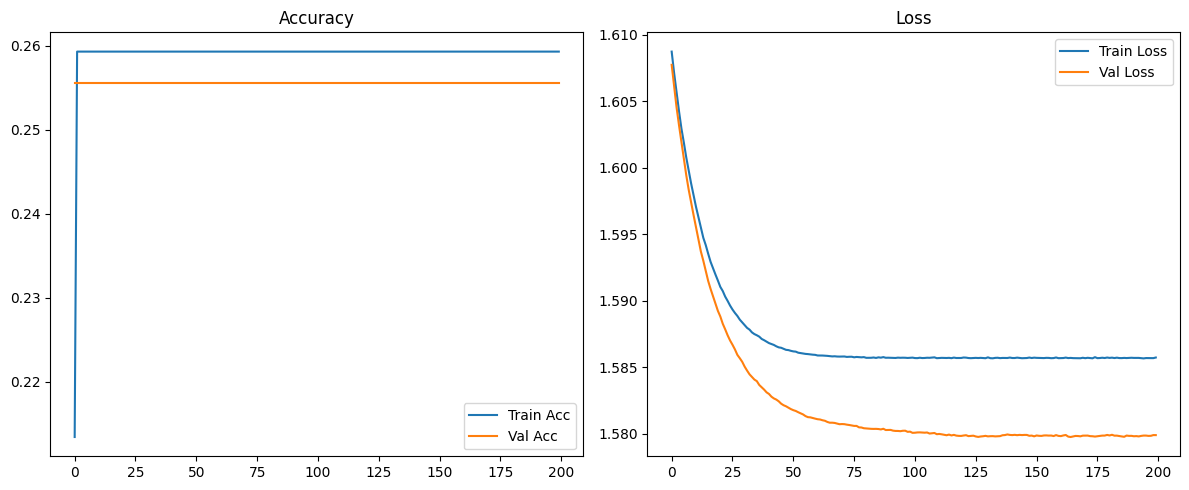

7/7 [==============================] - 0s 2ms/step
Total Inference Time: 0.226s | Per sample: 0.001009s
Accuracy: 0.25892857142857145
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.26      1.00      0.41        58
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00        51
           4       0.00      0.00      0.00        45

    accuracy                           0.26       224
   macro avg       0.05      0.20      0.08       224
weighted avg       0.07      0.26      0.11       224

Confusion Matrix:
 [[ 0 30  0  0  0]
 [ 0 58  0  0  0]
 [ 0 40  0  0  0]
 [ 0 51  0  0  0]
 [ 0 45  0  0  0]]
Macro ROC AUC: 0.5


c:\ProgramData\anaconda3\envs\Shihab_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\Shihab_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\Shihab_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

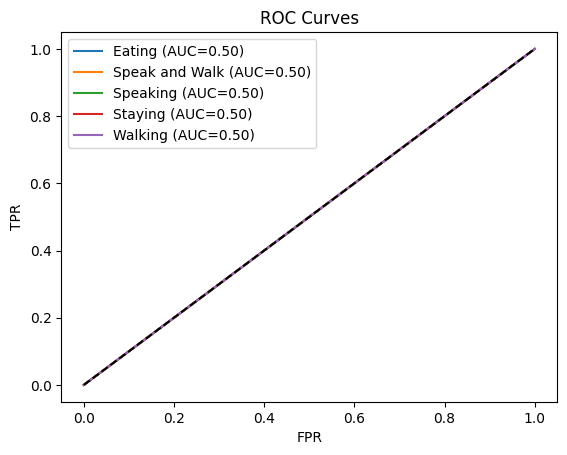

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from tensorflow.keras import layers, models, utils

# --- 1. Data Preparation ---
df = pd.read_csv(r"E:\AllData.csv").drop(['Time', 'Person'], axis=1)
sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

window_size = 128
stride = window_size // 2
X, y = [], []
for label in df['Class'].unique():
    vals = df[df['Class'] == label][sensor_cols].values
    for start in range(0, len(vals) - window_size + 1, stride):
        X.append(vals[start:start+window_size])
        y.append(label)
X = np.array(X, dtype=np.float32)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
num_classes = len(np.unique(y))
y_train_cat = utils.to_categorical(y_train, num_classes)
y_test_cat = utils.to_categorical(y_test, num_classes)

# --- 2. SNN Components ---
class LIFNeuron(tf.keras.layers.Layer):
    def __init__(self, tau=20.0, threshold=1.0, **kwargs):
        super().__init__(**kwargs)
        self.tau = tau
        self.threshold = threshold

    def call(self, inputs, training=None):
        mem = tf.zeros_like(inputs)
        mem = (1.0 - 1.0 / self.tau) * mem + inputs / self.tau
        spikes = tf.cast(mem >= self.threshold, tf.float32)
        mem = tf.where(spikes > 0, 0.0, mem)
        return spikes

    def get_config(self):
        config = super().get_config()
        config.update({
            "tau": self.tau,
            "threshold": self.threshold
        })
        return config

# --- 3. SNN-HAR Model ---
def build_snn_har(input_shape, num_classes):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, 5, padding='same', activation='relu')(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)

    spike_out = LIFNeuron()(x)
    out = layers.Dense(num_classes, activation='softmax')(spike_out)

    return models.Model(inputs=inp, outputs=out, name="SNN_HAR")

model = build_snn_har(input_shape=(window_size, len(sensor_cols)), num_classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- 4. Model Size ---
param_count = model.count_params()
print("Parameter count:", param_count)
model.save("snn_har_model.h5")
size_mb = os.path.getsize("snn_har_model.h5") / (1024 * 1024)
print(f"Model file size: {size_mb:.2f} MB")
os.remove("snn_har_model.h5")

# --- 5. Training ---
history = model.fit(X_train, y_train_cat, epochs=200, batch_size=64, validation_split=0.1)

# --- 6. Training/Validation Curves ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.tight_layout(); plt.show()

# --- 7. Evaluation ---
start = time.time()
y_pred_probs = model.predict(X_test)
inference_time = time.time() - start
y_pred = np.argmax(y_pred_probs, axis=1)

print(f"Total Inference Time: {inference_time:.3f}s | Per sample: {inference_time/len(X_test):.6f}s")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- 8. ROC & AUC ---
macro_auc = roc_auc_score(y_test_cat, y_pred_probs, multi_class='ovr')
print("Macro ROC AUC:", macro_auc)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{le.inverse_transform([i])[0]} (AUC={roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend()
plt.show()


HAR-Transformer

Model: "HARTransformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_inputs (InputLayer)        [(None, 128, 6)]     0           []                               
                                                                                                  
 enc_dense_proj (Dense)         (None, 128, 128)     896         ['enc_inputs[0][0]']             
                                                                                                  
 learned_positional_embedding (  (None, 128, 128)    16384       ['enc_dense_proj[0][0]']         
 LearnedPositionalEmbedding)                                                                      
                                                                                                  
 dec_inputs (InputLayer)        [(None, 128, 5)]     0           []                  

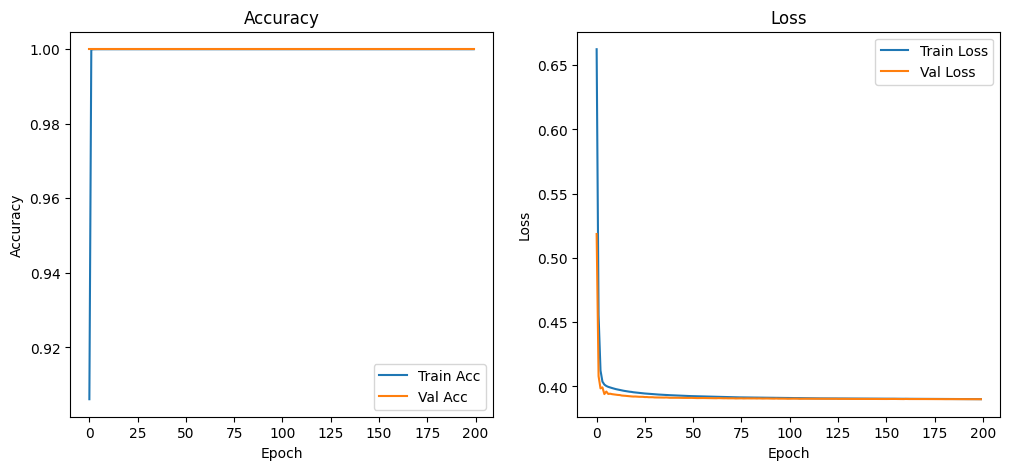

=== HAR-Transformer Evaluation ===
7/7 [==============================] - 1s 52ms/step
Test Accuracy (majority vote): 1.0
Inference time total: 1.086 s (0.004847 s/sample)
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        51
           4       1.00      1.00      1.00        45

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224

Confusion Matrix:
 [[30  0  0  0  0]
 [ 0 58  0  0  0]
 [ 0  0 40  0  0]
 [ 0  0  0 51  0]
 [ 0  0  0  0 45]]
ROC AUC (macro): 1.0


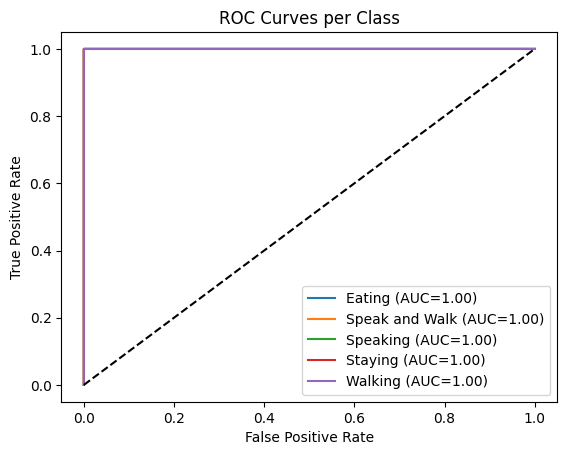

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score,
    roc_curve, auc
)
import tensorflow as tf
from tensorflow.keras import layers, models, utils, losses, optimizers

# --- Data Preparation ---

df = pd.read_csv(r"E:\AllData.csv")
df = df.drop(['Time', 'Person'], axis=1)

sensor_cols = ['Acc_x', 'Acc_y', 'Acc_z', 'Gry_x', 'Gry_y', 'Gry_Z']
df[sensor_cols] = (df[sensor_cols] - df[sensor_cols].mean()) / df[sensor_cols].std()

le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

window_size = 128
stride = window_size // 2

X, y = [], []
for label in df['Class'].unique():
    vals = df[df['Class'] == label][sensor_cols].values
    for start in range(0, len(vals) - window_size + 1, stride):
        X.append(vals[start:start + window_size])
        y.append(label)

X = np.array(X)
y = np.array(y)

# For seq2seq output: repeat label per timestep to create label sequence
y_seq = np.tile(y[:, None], (1, window_size))

X_train, X_test, y_train_seq, y_test_seq = train_test_split(
    X, y_seq, test_size=0.2, stratify=y, random_state=42
)

num_classes = len(np.unique(y))

# One-hot encode targets (batch, seq_len, num_classes)
y_train_cat = utils.to_categorical(y_train_seq, num_classes)
y_test_cat = utils.to_categorical(y_test_seq, num_classes)

# --- Learned Positional Embedding ---
class LearnedPositionalEmbedding(layers.Layer):
    def __init__(self, seq_len, dim):
        super().__init__()
        self.seq_len = seq_len
        self.dim = dim
        self.pos_embedding = layers.Embedding(input_dim=seq_len, output_dim=dim)

    def call(self, x):
        positions = tf.range(start=0, limit=self.seq_len, delta=1)
        pos_emb = self.pos_embedding(positions)
        return x + pos_emb

    def get_config(self):
        config = super().get_config()
        config.update({"seq_len": self.seq_len, "dim": self.dim})
        return config

# --- Encoder Block with unique names ---
def encoder_layer(d_model, num_heads, dff, dropout_rate=0.1, name_suffix="0"):
    inputs = layers.Input(shape=(None, d_model), name=f"enc_input_{name_suffix}")

    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model, name=f"enc_attn_{name_suffix}"
    )(inputs, inputs)
    attn_output = layers.Dropout(dropout_rate, name=f"enc_dropout1_{name_suffix}")(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6, name=f"enc_layernorm1_{name_suffix}")(inputs + attn_output)

    ffn = models.Sequential([
        layers.Dense(dff, activation='relu', name=f"enc_dense1_{name_suffix}"),
        layers.Dense(d_model, name=f"enc_dense2_{name_suffix}")
    ], name=f"enc_ffn_{name_suffix}")

    ffn_output = ffn(out1)
    ffn_output = layers.Dropout(dropout_rate, name=f"enc_dropout2_{name_suffix}")(ffn_output)
    out2 = layers.LayerNormalization(epsilon=1e-6, name=f"enc_layernorm2_{name_suffix}")(out1 + ffn_output)

    return models.Model(inputs=inputs, outputs=out2, name=f"EncoderLayer_{name_suffix}")

# --- Decoder Block with unique names ---
def decoder_layer(d_model, num_heads, dff, dropout_rate=0.1, name_suffix="0"):
    inputs = layers.Input(shape=(None, d_model), name=f"dec_input_{name_suffix}")
    enc_outputs = layers.Input(shape=(None, d_model), name=f"dec_enc_output_{name_suffix}")

    seq_len = tf.shape(inputs)[1]
    look_ahead_mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)  # Lower triangle
    look_ahead_mask = 1 - look_ahead_mask  # invert mask
    look_ahead_mask = look_ahead_mask[tf.newaxis, :, :]  # batch dim

    attn1 = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model, name=f"dec_self_attn_{name_suffix}"
    )(inputs, inputs, attention_mask=look_ahead_mask)
    attn1 = layers.Dropout(dropout_rate, name=f"dec_dropout1_{name_suffix}")(attn1)
    out1 = layers.LayerNormalization(epsilon=1e-6, name=f"dec_layernorm1_{name_suffix}")(inputs + attn1)

    attn2 = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model, name=f"dec_enc_attn_{name_suffix}"
    )(out1, enc_outputs)
    attn2 = layers.Dropout(dropout_rate, name=f"dec_dropout2_{name_suffix}")(attn2)
    out2 = layers.LayerNormalization(epsilon=1e-6, name=f"dec_layernorm2_{name_suffix}")(out1 + attn2)

    ffn = models.Sequential([
        layers.Dense(dff, activation='relu', name=f"dec_dense1_{name_suffix}"),
        layers.Dense(d_model, name=f"dec_dense2_{name_suffix}")
    ], name=f"dec_ffn_{name_suffix}")

    ffn_output = ffn(out2)
    ffn_output = layers.Dropout(dropout_rate, name=f"dec_dropout3_{name_suffix}")(ffn_output)
    out3 = layers.LayerNormalization(epsilon=1e-6, name=f"dec_layernorm3_{name_suffix}")(out2 + ffn_output)

    return models.Model(inputs=[inputs, enc_outputs], outputs=out3, name=f"DecoderLayer_{name_suffix}")

# --- Build HAR-Transformer Model ---
def build_har_transformer_full(seq_len, num_features, num_classes,
                               d_model=128, num_heads=4, dff=512, num_layers=3,
                               dropout=0.1):
    enc_inputs = layers.Input(shape=(seq_len, num_features), name="enc_inputs")
    dec_inputs = layers.Input(shape=(seq_len, num_classes), name="dec_inputs")

    enc_embedding = layers.Dense(d_model, name="enc_dense_proj")(enc_inputs)
    enc_embedding = LearnedPositionalEmbedding(seq_len, d_model)(enc_embedding)
    enc_embedding = layers.Dropout(dropout, name="enc_dropout")(enc_embedding)

    enc_out = enc_embedding
    for i in range(num_layers):
        enc_layer = encoder_layer(d_model, num_heads, dff, dropout, name_suffix=str(i))
        enc_out = enc_layer(enc_out)

    dec_embedding = layers.Dense(d_model, name="dec_dense_proj")(dec_inputs)
    dec_embedding = LearnedPositionalEmbedding(seq_len, d_model)(dec_embedding)
    dec_embedding = layers.Dropout(dropout, name="dec_dropout")(dec_embedding)

    dec_out = dec_embedding
    for i in range(num_layers):
        dec_layer = decoder_layer(d_model, num_heads, dff, dropout, name_suffix=str(i))
        dec_out = dec_layer([dec_out, enc_out])

    outputs = layers.Dense(num_classes, activation='softmax', name="final_classifier")(dec_out)

    return models.Model(inputs=[enc_inputs, dec_inputs], outputs=outputs, name="HARTransformer")

# --- Instantiate Model ---
model = build_har_transformer_full(
    seq_len=window_size,
    num_features=len(sensor_cols),
    num_classes=num_classes,
    d_model=128,
    num_heads=4,
    dff=512,
    num_layers=3,
    dropout=0.1
)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss=losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()

# Print params and model size
param_count = model.count_params()
print("Model parameter count:", param_count)
model_path = "har_transformer_model_temp.h5"
model.save(model_path)
model_file_size_mb = os.path.getsize(model_path) / (1024 * 1024)
print(f"Model file size: {model_file_size_mb:.2f} MB")
os.remove(model_path)

# Decoder inputs for teacher forcing
def create_decoder_input(y_seq_onehot):
    start_token = np.zeros((y_seq_onehot.shape[0], 1, y_seq_onehot.shape[2]))
    return np.concatenate([start_token, y_seq_onehot[:, :-1, :]], axis=1)

y_train_dec_in = create_decoder_input(y_train_cat)
y_test_dec_in = create_decoder_input(y_test_cat)

# --- Train ---
history = model.fit(
    [X_train, y_train_dec_in], y_train_cat,
    validation_split=0.1,
    epochs=200,
    batch_size=64,
    verbose=1
)

# --- Plot train/val curves ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# --- Evaluation ---
print("=== HAR-Transformer Evaluation ===")
start_time = time.time()

y_pred_probs = model.predict([X_test, y_test_dec_in])
inference_time = time.time() - start_time

# Majority vote collapsing sequence preds to single label per sample
from scipy.stats import mode
y_pred_seq = np.argmax(y_pred_probs, axis=-1)
y_pred_majority = mode(y_pred_seq, axis=1).mode.flatten()

print("Test Accuracy (majority vote):", accuracy_score(y_test_seq[:, 0], y_pred_majority))
print(f"Inference time total: {inference_time:.3f} s ({inference_time / len(X_test):.6f} s/sample)")

print("Classification Report:\n", classification_report(y_test_seq[:, 0], y_pred_majority))
print("Confusion Matrix:\n", confusion_matrix(y_test_seq[:, 0], y_pred_majority))

macro_auc = roc_auc_score(
    y_test_cat.reshape(-1, num_classes),
    y_pred_probs.reshape(-1, num_classes),
    multi_class='ovr'
)
print("ROC AUC (macro):", macro_auc)

# ROC curves per class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, :, i].flatten(), y_pred_probs[:, :, i].flatten())
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{le.inverse_transform([i])[0]} (AUC={roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves per Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
